<b> This file simulates the systems of two bosonic modes coupled via a SNAIL device. 
<br> Parameters followed the reference http://arxiv.org/abs/2212.11929
<br> Code developed by Xinyuan You and Yao Lu, 2023 

<b> This file calculates the beam splitter rate in the presence of periodic drive

### Load library and setup plot 

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy
from scipy.optimize import fsolve
from math import factorial

In [2]:
fig_width_pt = 246.0  
inches_per_pt = 1.0/72.27             
golden_mean = (np.sqrt(5)-1.0)/2.0    
fig_width = fig_width_pt*inches_per_pt 
fig_height = fig_width/1.5 
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [fig_width, fig_height]
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'times'

### Define parameters

In [3]:
M = 3   # number of large JJs in a SNAIL
EJ = 90 * 2*np.pi   # junction energy of larger JJ 
EL = 64 * 2*np.pi   # linear inductive energy of the SNAIL
EC = 177e-3 * 2*np.pi   # charging energy of the SNAIL 
beta = 0.147   # ratio between small and large JJ 
phi_ext = 0.35 * 2*np.pi   # external flux in SNAIL, e.g., 2pi = 1 flux quantum 

w_a = 2.97 * 2*np.pi   # frequency of Alice mode 
w_b = 6.915 * 2*np.pi   # frequency of Bob mode 

g_ac = 75.6e-3 * 2*np.pi   # coupling strength between Alice and SNAIL
g_bc = 134.9e-3 * 2*np.pi   # coupling strength between Bob and SNAIL 

chi_a_q = -766e-6 * 2*np.pi   # dispersive shift between Alice and its ancilla transmon
anh_a_q = -181e-3 * 2*np.pi   # anharmonicity of Alice's transmon
chi_b_q = -1104e-6 * 2*np.pi   # dispersive shift between Bob and its ancilla transmon
anh_b_q = -184e-3 * 2*np.pi   # anharmonicity of Bob's transmon

dim_SNAIL = 40   # level cutoff of SNAIL using oscillator basis (expanded around the equilibrium in potential)
dim_alice = 5   # level cutoff of Alice using oscillator basis 
dim_bob = 5   # level cutoff of Bob using oscillator basis 
dim = dim_SNAIL * dim_alice * dim_bob   # total dimension of the coupled system 

- SNAIL dimension should be tested to ensure convergence

### Define operators 

In [4]:
c_opt = tensor(qeye(dim_alice), destroy(dim_SNAIL), qeye(dim_bob))   # annihilation operator of SNAIL  
a_opt = tensor(destroy(dim_alice), qeye(dim_SNAIL), qeye(dim_bob))   # annihilation operator of Alice  
b_opt = tensor(qeye(dim_alice), qeye(dim_SNAIL), destroy(dim_bob))   # annihilation operator of Bob  

### Calculate the minimum of the potential, which is used to define the oscillator basis 

In [5]:
def potential_min(phi_min, phi_ext):
    return beta * np.sin(phi_min - phi_ext) + np.sin(phi_min/M)

### Construct the static Hamiltonian

In [6]:
phi_min = fsolve(potential_min, 0, args=phi_ext)[0]

# Taylor coefficients of the expansion around potential minimum [ref. B7]
c2 = beta * np.cos(phi_min - phi_ext) + np.cos(phi_min/M)/M
c3 = (M**2-1)/M**2 * np.sin(phi_min/M)
c4 = -beta * np.cos(phi_min - phi_ext) - np.cos(phi_min/M)/M**3
c5 = (1-M**4)/M**4 * np.sin(phi_min/M)

p = EL / (c2 * EJ + EL)

# renormalized coefficient due to the linear inductor [ref. B9]
c2_ti = p * c2
c3_ti = p**3 * c3
c4_ti = p**4 * (c4 - 3*c3**2/c2*(1-p))
c5_ti = p**5 *(c5 - 10*c4*c3/c2*(1-p) + 15*c3**3/c2**2*(1-p)**2)

# zero point fluctuation of the linearized SNAIL
phi_c = (2*EC / c2_ti / EJ)**0.25

# analytical approximation of SNAIL nonlinearity and frequency [ref. B8]
wc = np.sqrt(8*c2_ti*EC*EJ)
g3 = EJ * phi_c**3 * c3_ti / factorial(3)
g4 = EJ * phi_c**4 * c4_ti / factorial(4)
g5 = EJ * phi_c**5 * c5_ti / factorial(5)
anh = 12 * (g4 - 5 * g3**2/wc)

# construct the SNAIL Hamiltonian up to 5th order nonlinearity 
h_SNAIL = wc * c_opt.dag() * c_opt + g3 * (c_opt + c_opt.dag())**3 + g4 * (c_opt + c_opt.dag())**4 + g5 * (c_opt + c_opt.dag())**5

# constuct the coupled Alice--SNAIL--Bob Hamiltonian
h_tot = h_SNAIL + w_a * a_opt.dag() * a_opt + w_b * b_opt.dag() * b_opt + g_ac * (a_opt.dag()*c_opt + a_opt*c_opt.dag()) + g_bc * (b_opt.dag()*c_opt + b_opt*c_opt.dag()) 

- note the definition of $p$ in the ref. is incorrect
- note the expression of $\tilde{c_5}$ in the ref. is incorrect

### Construct the driven Hamiltonian

In [7]:
def H1_coeff(t, args):
    return args['eps'] * np.sin(args['omega'] * t) 

H1 = (c_opt.dag() - c_opt) * 1j
H_d = [h_tot,[H1, H1_coeff]]

- note the definition of $\epsilon$ here differs by a factor of 2 in the ref. 

### Construct mapping between Floquet basis to the undriven basis

In [8]:
# 'basis_mode' takes floquet modes
def get_energy(a_state, c_state, b_state, f_modes, f_energies, basis_mode):
    prob = 0
    energy = None
    index = -1
    for i in range(len(f_modes)):
        prob_i = np.abs((basis_mode.dag() * f_modes[i])[0]) ** 2
        if prob_i > prob:
            prob = prob_i
            energy = f_energies[i]
            index = i
    if prob < 0.5:
        print('Warning: max overlap < 0.5', a_state, c_state, b_state, prob[0][0])
    return energy / (2*np.pi), index

# 'basis_mode' takes eigenvecs of undriven system 
def get_energy_base(a_state, c_state, b_state, f_modes, f_energies):
    prob = 0
    energy = None
    index = -1
    for i in range(len(f_modes)):
        prob_i = np.abs((tensor(basis(dim_alice, a_state), 
                                basis(dim_SNAIL, c_state), 
                                basis(dim_bob, b_state)).dag() * f_modes[i])[0]) ** 2
        if prob_i > prob:
            prob = prob_i
            energy = f_energies[i]
            index = i
    if prob < 0.5:
        print('Warning: max overlap < 0.5', a_state, c_state, b_state, prob[0][0])
    return energy / (2*np.pi), index

### Define the range of driven amplitude and frequency to sweep

In [9]:
omega_list = np.linspace(3.93, 3.98, 50) * 2*np.pi
eps_list = np.linspace(0,1,2) * 2*np.pi

In [10]:
eng_mat_a10 = np.zeros((len(eps_list), len(omega_list)))
eng_mat_b10 = np.zeros((len(eps_list), len(omega_list)))
overlap_mat = np.zeros((len(eps_list), len(omega_list),2))
a1b0_mode_list = []
a0b1_mode_list = []
a0b0_mode_list = []

### Calculate the undriven reference eigenbasis

In [11]:
evals, evecs = h_tot.eigenstates(sparse=True)

undriven_eng_a1b0, index_a1b0 = get_energy_base(1,0,0,evecs,evals)
undriven_eng_a0b1, index_a0b1 = get_energy_base(0,0,1,evecs,evals)
undriven_eng_a0b0, index_a0b0 = get_energy_base(0,0,0,evecs,evals)

# the undriven eigvecs are used later for state overlap 
undriven_a1b0 = evecs[index_a1b0]
undriven_a0b1 = evecs[index_a0b1]
undriven_a0b0 = evecs[index_a0b0]

#  the undriven eigvecs are also used for the initial state mapping 
for i in range(len(omega_list)):
    a1b0_mode_list.append(undriven_a1b0)
    a0b1_mode_list.append(undriven_a0b1)
    a0b0_mode_list.append(undriven_a0b0)

### Calculate the Floquet energies and modes and relevant quantities

In [13]:
for j in range(len(eps_list)):
    eps = eps_list[j]   # update the drive amplitude 
    print(j)
    
    for i in range(len(omega_list)):
        omega = omega_list[i]   # update the drive frequency 
        
        # calcualte the propagator 
        prop = propagator(H_d, 2*np.pi/omega, [], args={'omega': omega, 'eps': eps}, parallel=True, options=Options(nsteps=10000))   
        # calculate the floquet modes and frequency 
        f_modes, f_energies = floquet_modes(H_d, 2*np.pi / omega, args={'omega': omega, 'eps': eps}, sort=True, U=prop)   
        
        # state mapping of the floquet modes 
        eng_a1b0, index_a1b0 = get_energy(1,0,0,f_modes,f_energies, a1b0_mode_list[i])
        eng_a0b1, index_a0b1 = get_energy(0,0,1,f_modes,f_energies, a0b1_mode_list[i])
        eng_a0b0, index_a0b0 = get_energy(0,0,0,f_modes,f_energies, a0b0_mode_list[i])
        
        # update the reference basis 
        a1b0_mode_list[i] = f_modes[index_a1b0]
        a0b1_mode_list[i] = f_modes[index_a0b1]
        a0b0_mode_list[i] = f_modes[index_a0b0]
        
        # store the floquet energy of Alice and Bob
        eng_mat_a10[j,i] = eng_a1b0 - eng_a0b0
        eng_mat_b10[j,i] = eng_a0b1 - eng_a0b0
        
        # store the overlap between driven mode a1b0 and undriven mode a0b1
        overlap_mat[j,i,0] = fidelity(ptrace(a1b0_mode_list[i],[0,2]), ptrace(undriven_a0b1,[0,2]) )**2
        overlap_mat[j,i,1] = fidelity(ptrace(a0b1_mode_list[i],[0,2]), ptrace(undriven_a1b0,[0,2]) )**2

0
1


In [14]:
# np.savez('gbs.npz',
#         eng_mat_a10 = eng_mat_a10,
#         eng_mat_b10 = eng_mat_b10,
#         overlap_mat = overlap_mat)

In [37]:
data = np.load('gbs.npz')
eng_mat_a10 = data['eng_mat_a10']
eng_mat_b10 = data['eng_mat_b10']
overlap_mat = data['overlap_mat']

### Unfold the Floquet energies 

In [38]:
for j in range(len(eps_list)):
    for i in range(len(omega_list)):
        while  eng_mat_a10[j,i] < w_a / (2*np.pi) * 0.8:
            eng_mat_a10[j,i] += omega_list[i] / (2*np.pi)
        while eng_mat_a10[j,i] > w_a / (2*np.pi) * 1.2:
            eng_mat_a10[j,i] -= omega_list[i] / (2*np.pi)
            
        while  eng_mat_b10[j,i] < w_b / (2*np.pi) * 0.8:
            eng_mat_b10[j,i] += omega_list[i] / (2*np.pi)
        while eng_mat_b10[j,i] > w_b / (2*np.pi) * 1.2:
            eng_mat_b10[j,i] -= omega_list[i] / (2*np.pi)

- need to double check with the following plots

### Plot the energy difference of a and b mode 

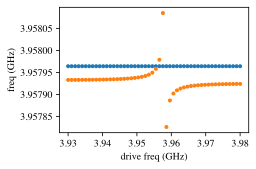

In [47]:
for j in range(len(eps_list)):
    plt.plot(omega_list/(2*np.pi), eng_mat_b10[j,:] - eng_mat_a10[j,:],'.' )
plt.xlabel('drive freq (GHz)')
plt.ylabel('freq (GHz)')
plt.show()

#### With the beam splitter Hamiltonian $H_{bs} = g(a^\dagger b e^{i\Delta t} + a b^\dagger e^{-i\Delta t})$ 
#### The avoided crossing between the energies of Alice and Bob follows $|\omega_a - \omega_b| = \sqrt{4g^2+\Delta^2}-\Delta$ (for $\Delta>0$)

In [48]:
gbs_avoid_list = np.zeros_like(eps_list)
xi_list = np.zeros_like(eps_list)

In [69]:
def fit_avoided_crossing(eps_index):
    j = eps_index
    eng_ab = eng_mat_b10[j,:] - eng_mat_a10[j,:]
    
    # define the cost function to fit the avoided crossing
    def cost_func(parameters):
        g = parameters[0]   # beam splitter rate 
        a = parameters[1]   # energy difference between two modes, excluding effects from avoided crossings 
        
        res = 0
        for i in range(len(omega_list)):
            # sometimes it is helpful to select the part of data to fit with 
            # if omega_list[i]/(2*np.pi)<3.95 or omega_list[i]/(2*np.pi) > 3.96:
                delta = omega_list[i]/(2*np.pi) - np.mean(eng_ab)
                res += np.abs(eng_ab[i] - (a - np.sign(delta) * np.sqrt(4*g**2 + delta**2) + delta) )**2 
        return res

    # boundaries of the fitting parameters 
    bb = scipy.optimize.Bounds(np.array([0, 3.95]), np.array([3e-3, 3.97]))
    
    # initial guess 
    x0 = np.array([1e-3, np.mean(eng_ab)])
    
    res = scipy.optimize.minimize(cost_func, x0, bounds=bb, method='Powell', tol=1e-7)
    
    # store fitted beam splitter rate, unit in MHz
    gbs_avoid_list[j] = res.x[0]*1e3   
    
    # update the displacements, notice the division by 2 here 
    xi_list[j] = np.abs(eps_list[j]/2/(res.x[1]*2*np.pi - wc))

    plt.plot(omega_list/(2*np.pi), eng_ab, '.')
    delta = omega_list/(2*np.pi) - res.x[1]
    plt.plot(omega_list/(2*np.pi), res.x[1] - np.sign(delta) * np.sqrt(4*res.x[0]**2 + delta**2) + delta ,'-c')

### fit for a specific drive amplitude

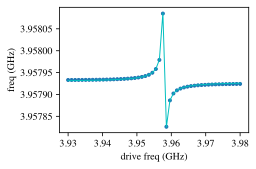

In [70]:
fit_avoided_crossing(1)
plt.xlabel('drive freq (GHz)')
plt.ylabel('freq (GHz)')
plt.show()

### fit for all drive amplitude 

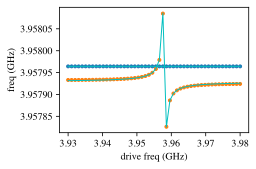

In [71]:
for j in range(len(eps_list)):
    fit_avoided_crossing(j)
plt.xlabel('drive freq (GHz)')
plt.ylabel('freq (GHz)')
plt.show()

#### With the beam splitter Hamiltonian $H_{bs} = g(a^\dagger b e^{i\Delta t} + a b^\dagger e^{-i\Delta t})$ 
#### The overlap between driven and undriven basis follows $\langle a0b1| \widetilde{a1b0}\rangle = \dfrac{\Delta + \sqrt{4g^2+\Delta^2}}{2g}$

In [61]:
gbs_overlap_list = np.zeros_like(eps_list)

In [66]:
def fit_overlap(eps_index):
    j = eps_index
    overlap_index = 0   # can take 0 or 1, should give similar results 
    eng_ab = eng_mat_b10[j,:] - eng_mat_a10[j,:]
    
    # define the cost function to fit the overlap 
    def cost_func(parameters):
        g = parameters[0]   # beam splitter rate 
        a = parameters[1]   # offset freq 
        
        res = 0
        for i in range(len(omega_list)):
            # sometimes it is helpful to select the part of data to fit with 
            # if  omega_list[i]/(2*np.pi) < 3.952 or omega_list[i]/(2*np.pi) > 3.96:
                delta = omega_list[i]/(2*np.pi) - np.mean(eng_ab) - a
                exp = (np.sqrt(delta**2 + 4*g**2) - np.abs(delta)) / (2*np.sqrt(delta**2 + 4*g**2))
                res += np.abs(overlap_mat[j,i,overlap_index] - exp)**2 
        return res 
    
    # boundaries of the fitting parameters 
    bb = scipy.optimize.Bounds(np.array([ 0, -0.001]), np.array([2e-3, 0.001]))
    
    # initial guess 
    x0 = np.array([  0.1e-3, 0])
    
    res = scipy.optimize.minimize(cost_func, x0, bounds=bb, method='Powell', tol=1e-7)

    # store fitted beam splitter rate, unit in MHz
    gbs_overlap_list[j] = res.x[0]*1e3
    
    plt.plot(omega_list/(2*np.pi), overlap_mat[j,:,overlap_index], '.')
    
    delta = omega_list/(2*np.pi) - np.mean(eng_ab) - res.x[1]
    exp = (np.sqrt(delta**2 + 4*res.x[0]**2) - np.abs(delta)) / (2*np.sqrt(delta**2 + 4*res.x[0]**2))
    plt.plot(omega_list/(2*np.pi), exp ,'-c')
    plt.ylim([1e-6, 0.1])

### fit for a specific drive amplitude

0.18875225258228107


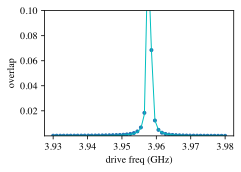

In [67]:
fit_overlap(1)
plt.xlabel('drive freq (GHz)')
plt.ylabel('overlap')
plt.show()

### fit for all drive amplitude 

0.0029589139097341444
0.18875225258228107


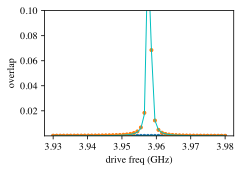

In [68]:
for j in range(len(eps_list)):
    fit_overlap(j)
plt.xlabel('drive freq (GHz)')
plt.ylabel('overlap')
plt.show()

### Compare the beam splitter rates obtained by the two methods, and with analytical approximation 

(0.0, 2.0)

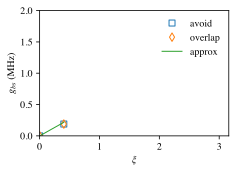

In [82]:
plt.plot(xi_list, gbs_avoid_list, 's', markerfacecolor='none')
plt.plot(xi_list, gbs_overlap_list, 'd', markerfacecolor='none')
plt.plot(xi_list, -1e3/(2*np.pi) * xi_list * g3 * 6 * g_bc * g_ac / (wc - w_b) / (wc - w_a), '-')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$g_{bs}$ (MHz)')
plt.legend(['avoid', 'overlap', 'approx'], frameon=False)
plt.xlim([0,3.16])
plt.ylim([0, 2])